# 함수 정의

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from collections import OrderedDict
import numpy as np
# mnist 파일 자동 다운로드
# MNIST 데이터 로드
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(-1, 784).astype('float32') / 255
x_test = x_test.reshape(-1, 784).astype('float32') / 255

t_train = tf.keras.utils.to_categorical(y_train, 10)
t_test = tf.keras.utils.to_categorical(y_test, 10)

11490434/11490434 [==============================] - 0s 0us/step


In [2]:
def identity_function(x):
    return x


def step_function(x):
    return np.array(x > 0, dtype=np.int)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)


def relu(x):
    return np.maximum(0, x)


def relu_grad(x):
    grad = np.zeros(x)
    grad[x>=0] = 1
    return grad


def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))


def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size


def softmax_loss(X, t):
    y = softmax(X)
    return cross_entropy_error(y, t)

def numerical_gradient(f, x):
    h = 1e-4  # 0.0001
    grad = np.zeros_like(x)

    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)  # f(x+h)

        x[idx] = tmp_val - h
        fxh2 = f(x)  # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)

        x[idx] = tmp_val  # 값 복원
        it.iternext()

    return grad

class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None  # 손실
        self.y = None     # softmax의 출력
        self.t = None     # 정답 레이블(원-핫 벡터)

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        return dx

class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b
        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        return dx


class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx

class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        return dx



class BatchNormalization:

    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None # 합성곱 계층은 4차원, 완전연결 계층은 2차원

        # 시험할 때 사용할 평균과 분산
        self.running_mean = running_mean
        self.running_var = running_var

        # backward 시에 사용할 중간 데이터
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None

    def forward(self, x, train_flg=True):
        self.input_shape = x.shape
        if x.ndim != 2:
            N, C, H, W = x.shape
            x = x.reshape(N, -1)

        out = self.__forward(x, train_flg)

        return out.reshape(*self.input_shape)

    def __forward(self, x, train_flg):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)

        if train_flg:
            mu = x.mean(axis=0)
            xc = x - mu
            var = np.mean(xc**2, axis=0)
            std = np.sqrt(var + 10e-7)
            xn = xc / std

            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1-self.momentum) * var
        else:
            xc = x - self.running_mean
            xn = xc / ((np.sqrt(self.running_var + 10e-7)))

        out = self.gamma * xn + self.beta
        return out

    def backward(self, dout):
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)

        dx = self.__backward(dout)

        dx = dx.reshape(*self.input_shape)
        return dx

    def __backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = np.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size

        self.dgamma = dgamma
        self.dbeta = dbeta

        return dx


def learning_rate_scheduler(iteration, lr_init=0.019, lr_final=0.001, max_iterations=10000):
    t = iteration / max_iterations
    lr = lr_final + (lr_init - lr_final) * (1 - t)
    return lr


# Optimizer

In [3]:
import numpy as np

class SGD:

    """확률적 경사 하강법（Stochastic Gradient Descent）"""

    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]


class Momentum:

    """모멘텀 SGD"""

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]


class Nesterov:

    """Nesterov's Accelerated Gradient (http://arxiv.org/abs/1212.0901)"""
    # NAG는 모멘텀에서 한 단계 발전한 방법이다. (http://newsight.tistory.com/224)

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] *= self.momentum
            self.v[key] -= self.lr * grads[key]
            params[key] += self.momentum * self.momentum * self.v[key]
            params[key] -= (1 + self.momentum) * self.lr * grads[key]


class AdaGrad:

    """AdaGrad"""

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


class RMSprop:

    """RMSprop"""

    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None

    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)

        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])

            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

# 신경망

In [4]:
class FourLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화 (He 초기화)
        self.params = {}
        self.params['W1'] = np.random.randn(input_size, hidden_size) * np.sqrt(2 / input_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = np.random.randn(hidden_size, hidden_size) * np.sqrt(2 / hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = np.random.randn(hidden_size, hidden_size) * np.sqrt(2 / hidden_size)
        self.params['b3'] = np.zeros(hidden_size)
        self.params['W4'] = np.random.randn(hidden_size, hidden_size) * np.sqrt(2 / hidden_size)
        self.params['b4'] = np.zeros(hidden_size)
        self.params['W5'] = np.random.randn(hidden_size, output_size) * np.sqrt(2 / hidden_size)
        self.params['b5'] = np.zeros(output_size)

        # 배치 정규화 파라미터 초기화
        self.params['gamma1'] = np.ones(hidden_size)
        self.params['beta1'] = np.zeros(hidden_size)
        self.params['gamma2'] = np.ones(hidden_size)
        self.params['beta2'] = np.zeros(hidden_size)
        self.params['gamma3'] = np.ones(hidden_size)
        self.params['beta3'] = np.zeros(hidden_size)
        self.params['gamma4'] = np.ones(hidden_size)
        self.params['beta4'] = np.zeros(hidden_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['BatchNorm1'] = BatchNormalization(self.params['gamma1'], self.params['beta1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['BatchNorm2'] = BatchNormalization(self.params['gamma2'], self.params['beta2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])
        self.layers['BatchNorm3'] = BatchNormalization(self.params['gamma3'], self.params['beta3'])
        self.layers['Relu3'] = Relu()
        self.layers['Affine4'] = Affine(self.params['W4'], self.params['b4'])
        self.layers['BatchNorm4'] = BatchNormalization(self.params['gamma4'], self.params['beta4'])
        self.layers['Relu4'] = Relu()
        self.layers['Affine5'] = Affine(self.params['W5'], self.params['b5'])
        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1:
            t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def update(self, grads, learning_rate):
        # 나머지 매개변수 업데이트
        for key in self.params.keys():
            self.params[key] -= learning_rate * grads[key]

    def gradient(self, x, t):
        # 순전파
        self.loss(x, t)

        # 역전파
        dout = 1
        dout = self.lastLayer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db
        grads['W3'] = self.layers['Affine3'].dW
        grads['b3'] = self.layers['Affine3'].db
        grads['W4'] = self.layers['Affine4'].dW
        grads['b4'] = self.layers['Affine4'].db
        grads['W5'] = self.layers['Affine5'].dW
        grads['b5'] = self.layers['Affine5'].db
        grads['gamma1'] = self.layers['BatchNorm1'].dgamma
        grads['beta1'] = self.layers['BatchNorm1'].dbeta
        grads['gamma2'] = self.layers['BatchNorm2'].dgamma
        grads['beta2'] = self.layers['BatchNorm2'].dbeta
        grads['gamma3'] = self.layers['BatchNorm3'].dgamma
        grads['beta3'] = self.layers['BatchNorm3'].dbeta
        grads['gamma4'] = self.layers['BatchNorm4'].dgamma
        grads['beta4'] = self.layers['BatchNorm4'].dbeta

        return grads

In [17]:
def shuffle_dataset(x, t):

  permutation = np.random.permutation(x.shape[0])
  x = x[permutation, :] if x.ndim == 2 else x[permutation, :, :, :]
  t = t[permutation]
  return x, t

# 파라미터 세팅(스케쥴러)

In [33]:
network = FourLayerNet(input_size=784, hidden_size=15, output_size=10)
iters_num = 10000  # 반복 횟수
train_size = x_train.shape[0]  # 훈련 데이터 개수
batch_size = 256  # 배치 크기
learning_rate_init = 0.019  # 초기 학습률
learning_rate_final = 0.001  # 최종 학습률

# Adam 옵티마이저 초기화
optimizer = RMSprop(lr=learning_rate)

# 학습 경과 기록용 리스트 초기화
train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size // batch_size, 1)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 학습률 스케줄링
    learning_rate = learning_rate_scheduler(i, lr_init=learning_rate_init, lr_final=learning_rate_final, max_iterations=iters_num)
    optimizer.lr = learning_rate

    # 기울기 계산
    grad = network.gradient(x_batch, t_batch)

    # 가중치 업데이트 (Adam)
    optimizer.update(network.params, grad)

    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(f"Iteration {i}, Learning Rate: {learning_rate}, Train Acc: {train_acc}, Test Acc: {test_acc}")

Iteration 0, Learning Rate: 0.019, Train Acc: 0.06538333333333333, Test Acc: 0.0671
Iteration 234, Learning Rate: 0.0185788, Train Acc: 0.9365833333333333, Test Acc: 0.9376
Iteration 468, Learning Rate: 0.0181576, Train Acc: 0.9487833333333333, Test Acc: 0.9456
Iteration 702, Learning Rate: 0.0177364, Train Acc: 0.9579166666666666, Test Acc: 0.954
Iteration 936, Learning Rate: 0.0173152, Train Acc: 0.9624166666666667, Test Acc: 0.9583
Iteration 1170, Learning Rate: 0.016894, Train Acc: 0.9623, Test Acc: 0.958
Iteration 1404, Learning Rate: 0.0164728, Train Acc: 0.9666666666666667, Test Acc: 0.956
Iteration 1638, Learning Rate: 0.0160516, Train Acc: 0.9684833333333334, Test Acc: 0.9578
Iteration 1872, Learning Rate: 0.0156304, Train Acc: 0.9703166666666667, Test Acc: 0.9614
Iteration 2106, Learning Rate: 0.015209199999999999, Train Acc: 0.9703333333333334, Test Acc: 0.9629
Iteration 2340, Learning Rate: 0.014787999999999999, Train Acc: 0.9693666666666667, Test Acc: 0.9592
Iteration 2574

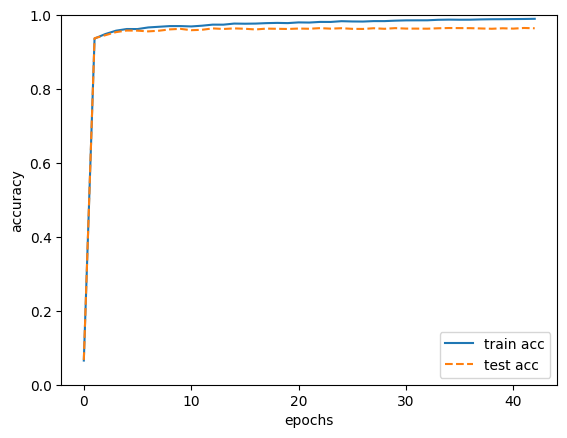

In [34]:
import matplotlib.pyplot as plt

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

# Hidden_size 150 설정

In [51]:
network = FourLayerNet(input_size=784, hidden_size=150, output_size=10, dropout_ratio=0.5)
iters_num = 10000  # 반복 횟수
train_size = x_train.shape[0]  # 훈련 데이터 개수
batch_size = 256  # 배치 크기
learning_rate_init = 0.019  # 초기 학습률
learning_rate_final = 0.001  # 최종 학습률

# Adam 옵티마이저 초기화
optimizer = RMSprop(lr=learning_rate)

# 학습 경과 기록용 리스트 초기화
train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size // batch_size, 1)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 학습률 스케줄링
    learning_rate = learning_rate_scheduler(i, lr_init=learning_rate_init, lr_final=learning_rate_final, max_iterations=iters_num)
    optimizer.lr = learning_rate

    # 기울기 계산
    grad = network.gradient(x_batch, t_batch)

    # 가중치 업데이트 (Adam)
    optimizer.update(network.params, grad)

    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(f"Iteration {i}, Learning Rate: {learning_rate}, Train Acc: {train_acc}, Test Acc: {test_acc}")

Iteration 0, Learning Rate: 0.019, Train Acc: 0.20336666666666667, Test Acc: 0.2025
Iteration 234, Learning Rate: 0.0185788, Train Acc: 0.9494833333333333, Test Acc: 0.9468
Iteration 468, Learning Rate: 0.0181576, Train Acc: 0.96145, Test Acc: 0.9577
Iteration 702, Learning Rate: 0.0177364, Train Acc: 0.9682166666666666, Test Acc: 0.9628
Iteration 936, Learning Rate: 0.0173152, Train Acc: 0.97275, Test Acc: 0.9673
Iteration 1170, Learning Rate: 0.016894, Train Acc: 0.9758166666666667, Test Acc: 0.9711
Iteration 1404, Learning Rate: 0.0164728, Train Acc: 0.97815, Test Acc: 0.9733
Iteration 1638, Learning Rate: 0.0160516, Train Acc: 0.9793833333333334, Test Acc: 0.9725
Iteration 1872, Learning Rate: 0.0156304, Train Acc: 0.97945, Test Acc: 0.9733
Iteration 2106, Learning Rate: 0.015209199999999999, Train Acc: 0.9809166666666667, Test Acc: 0.9756
Iteration 2340, Learning Rate: 0.014787999999999999, Train Acc: 0.9824, Test Acc: 0.9747
Iteration 2574, Learning Rate: 0.014366799999999999, Tr

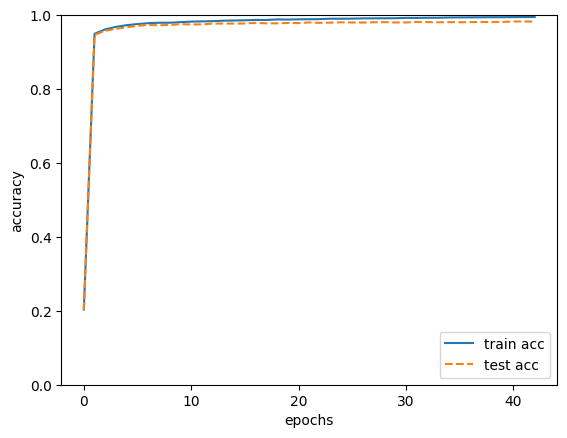

In [52]:
import matplotlib.pyplot as plt

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()